In [1]:
from Models import ResNet101Meta
import Dataset as dataset
from Train import train, plot_train_hist
from Evaluate import evaluate
from torch import nn
import torch

In [2]:
# Load and Preprocess Data
df = dataset.get_df("ISIC_2020_Training_GroundTruth_v2.csv")
train_df, val_df, test_df = dataset.group_split_df(df)
train_transform, val_transform, test_transform = dataset.transforms(img_size=224)

train_ds = dataset.MelanomaDS(train_df, train_transform, use_meta=True, mode='Train')
val_ds   = dataset.MelanomaDS(val_df,   val_transform,   use_meta=True, mode='Train')
test_ds  = dataset.MelanomaDS(test_df,  test_transform,   use_meta=True, mode = 'Test')

sampler, pos_weight = dataset.sampler(train_df)
train_loader = dataset.DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4)
val_loader = dataset.DataLoader(val_ds, batch_size=64, num_workers=4)
test_loader = dataset.DataLoader(test_ds, batch_size=64, num_workers=4)

In [3]:
# Set up Model
net = ResNet101Meta(train_ds.meta.shape[1]).to(device = 'mps')
criterion = nn.BCEWithLogitsLoss() # without weighted loss # criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) # with weighted loss
opt = torch.optim.AdamW([
    {"params": net.backbone.layer4.parameters(), "lr": 1e-5},
    {"params": net.head.parameters(), "lr": 1e-4}
])

# Train only the last layers (freeze the backbone)
for p in net.backbone.parameters():
    p.requires_grad = False
for p in net.backbone.layer4.parameters():
    p.requires_grad = True
for p in net.head.parameters():
    p.requires_grad = True

hist_train_loss, hist_val_loss, hist_val_acc = train(net, train_loader, val_loader, criterion, opt,
                                                     epochs = 3, best_model_name = "Best_Resnet101_meta.pt")

Epoch 1/3 AUC=0.8035
Saved new best model at epoch 1 with AUC=0.8035

Epoch 1/3


Epoch 2/3 AUC=0.8344
Saved new best model at epoch 2 with AUC=0.8344

Epoch 2/3


Epoch 3/3 AUC=0.8381
Saved new best model at epoch 3 with AUC=0.8381

Epoch 3/3
Best validation AUC: 0.8381


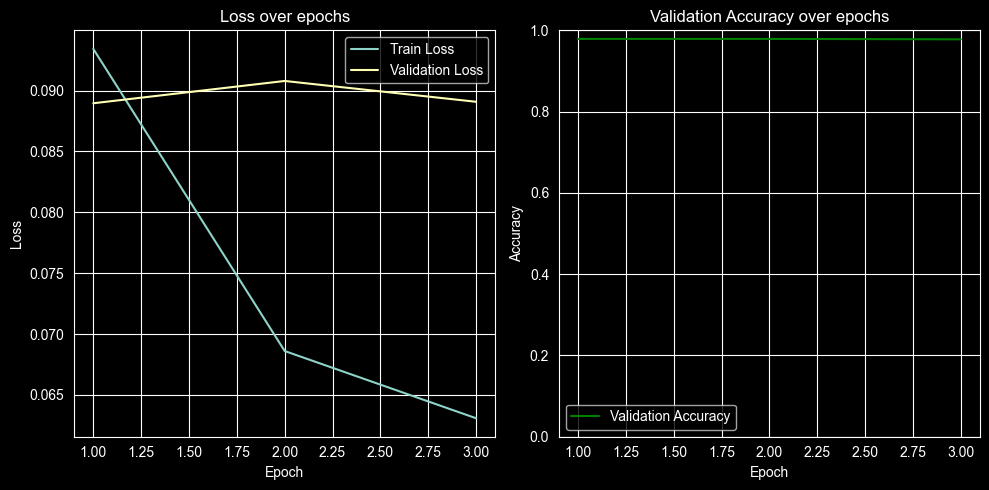

In [6]:
plot_train_hist(hist_train_loss, hist_val_loss, hist_val_acc, epochs = 3)

100%|██████████| 107/107 [03:28<00:00,  1.94s/it]

Test AUC: 0.8676 Test Accuracy: 0.9840


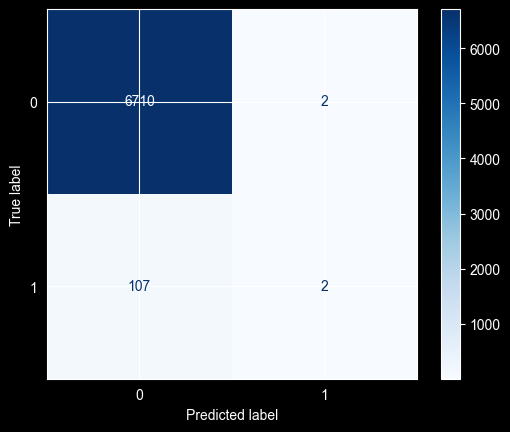

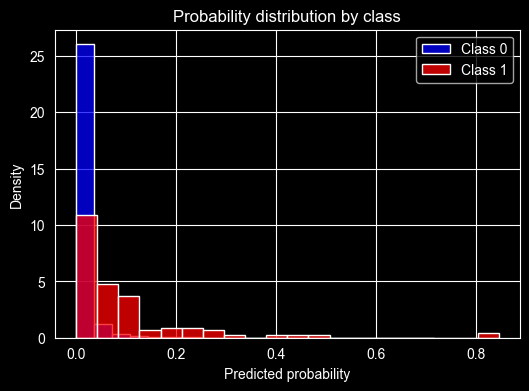

In [4]:
# Load Saved Model
state_dict = torch.load("Best_Resnet101_meta.pt", map_location=device)
net.load_state_dict(state_dict)

cm, ys, ps, idx = evaluate(net, test_loader, device = 'mps', use_meta= True, threshold=0.5)